## Name: Anupam Tiwari,  Net id: ast9885

design a backdoor detector for BadNets trained on the YouTube Face dataset using the pruning defense discussed in class

input:
1. B, a backdoored neural network classifier with N classes.
2. Dvalid, a validation dataset of clean, labelled images.

output:
1. G a “repaired” BadNet
2. G has N+1 classes, and given unseen test input
3. Output the correct class if the test input is clean. The correct class will be in [1,N].
4. Output class N+1 if the input is backdoored.

In [37]:
import keras
import h5py
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")

### data loading and drive mount

In [38]:
def loader(filepath):
  raw = h5py.File(filepath, 'r')
  data_,label = np.array(raw['data']), np.array(raw['label'])
  data_ = data_.transpose((0,2,3,1))
  return data_,label

# Visualizing data

#### clean data vs poisoned data

In [39]:
cl_data, cl_label = loader('lab3/data/cl/valid.h5')
bd_data, bd_label = loader('lab3/data/bd/bd_valid.h5')

ValueError: num must be 1 <= num <= 18, not 19

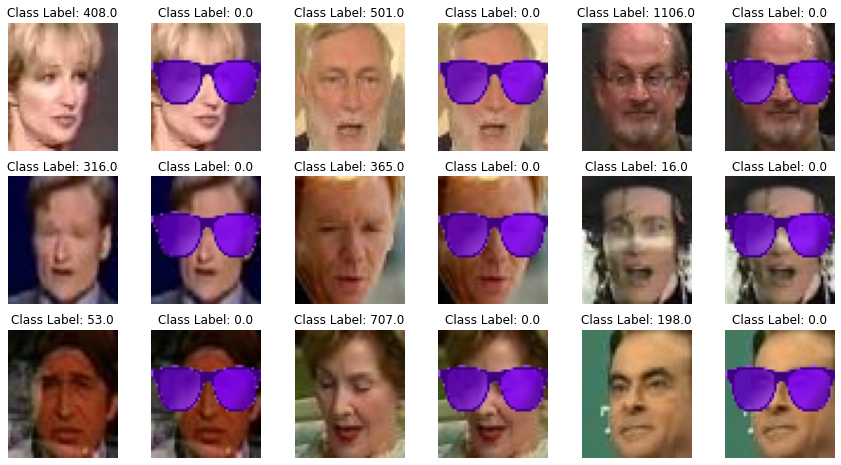

In [40]:
figure = plt.figure(figsize=(15,8))
cols, rows = 6,3
for i in range(1,cols*rows+1):
  index = np.random.randint(cl_data.shape[0], size=1)
  img1,label1 = (cl_data[index],cl_label[index])
  img2,label2 = (bd_data[index],bd_label[index])

  figure.add_subplot(rows, cols, 2 * i-1)
  plt.axis("off")
  plt.imshow(img1[0] / 255)
  plt.title("Class Label: {}".format(label1[0]))

  figure.add_subplot(rows, cols, 2 * i)
  plt.axis("off")
  plt.imshow(img2[0] / 255)
  plt.title("Class Label: {}".format(label2[0]))
plt.show()

##  badnet predictions

In [41]:
bad_net_model = keras.models.load_model('lab3/models/bd_net.h5')
bad_net_weigh = 'lab3/models/bd_weights.h5'
bad_net_model.load_weights(bad_net_weigh)
cl_label_predicted = np.argmax(bad_net_model.predict(cl_data),axis=1)
print('clean accuracy',np.mean(np.equal(cl_label_predicted,cl_label))*100)
bd_label_predicted = np.argmax(bad_net_model.predict(bd_data),axis=1)
print('attact success rate',np.mean(np.equal(bd_label_predicted,bd_label))*100)

361/361 [==============================] - 3s 7ms/step
clean accuracy 98.64899974019225
361/361 [==============================] - 3s 7ms/step
attact success rate 100.0


## model:

In [42]:
print(bad_net_model.summary())
keras.backend.clear_session()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

# pruning

You will design G using the pruning defense that we discussed in class. That is, you will prune
the last pooling layer of BadNet B (the layer just before the FC layers) by removing one
channel at a time from that layer. Channels should be removed in decreasing order of average
activation values over the entire validation set. Every time you prune a channel, you will
measure the new validation accuracy of the new pruned badnet. You will stop pruning once the
validation accuracy drops atleast X% below the original accuracy. This will be your new
network B'.
Now, your goodnet G works as follows. For each test input, you will run it through both B and
B'. If the classification outputs are the same, i.e., class i, you will output class i. If they differ you
will output N+1

In [43]:
clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(bad_net_model)
model_copy.set_weights(bad_net_model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

In [44]:
# getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_data)
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

361/361 [==============================] - 2s 6ms/step


In [45]:
for channel_index in tqdm(seq):
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_data), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_label))*100

  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1

  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1

  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1

  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_data), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_label))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()

  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 3s 7ms/step


  2%|▏         | 1/60 [00:06<06:18,  6.41s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26


  3%|▎         | 2/60 [00:12<06:16,  6.49s/it]

361/361 [==============================] - 3s 7ms/step


  5%|▌         | 3/60 [00:19<06:09,  6.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27
361/361 [==============================] - 2s 7ms/step


  7%|▋         | 4/60 [00:25<06:02,  6.47s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 2s 7ms/step


  8%|▊         | 5/60 [00:32<05:53,  6.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 2s 7ms/step


 10%|█         | 6/60 [00:38<05:46,  6.42s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
361/361 [==============================] - 2s 7ms/step


 12%|█▏        | 7/60 [00:45<05:39,  6.40s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36


 13%|█▎        | 8/60 [00:51<05:30,  6.36s/it]

361/361 [==============================] - 2s 7ms/step


 15%|█▌        | 9/60 [00:57<05:24,  6.36s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 2s 7ms/step


 17%|█▋        | 10/60 [01:03<05:17,  6.36s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38
361/361 [==============================] - 2s 7ms/step


 18%|█▊        | 11/60 [01:10<05:12,  6.38s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 3s 7ms/step


 20%|██        | 12/60 [01:16<05:07,  6.41s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 2s 7ms/step


 22%|██▏       | 13/60 [01:23<05:02,  6.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 3s 7ms/step


 23%|██▎       | 14/60 [01:29<04:58,  6.48s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45


 25%|██▌       | 15/60 [01:36<04:50,  6.46s/it]

361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47


 27%|██▋       | 16/60 [01:42<04:43,  6.45s/it]

361/361 [==============================] - 2s 7ms/step


 28%|██▊       | 17/60 [01:49<04:37,  6.44s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 3s 7ms/step


 30%|███       | 18/60 [01:55<04:30,  6.45s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50


 32%|███▏      | 19/60 [02:02<04:24,  6.44s/it]

361/361 [==============================] - 2s 7ms/step


 33%|███▎      | 20/60 [02:08<04:16,  6.41s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 2s 7ms/step


 35%|███▌      | 21/60 [02:15<04:13,  6.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40


 37%|███▋      | 22/60 [02:21<04:06,  6.48s/it]

361/361 [==============================] - 2s 7ms/step


 38%|███▊      | 23/60 [02:27<03:58,  6.44s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
361/361 [==============================] - 2s 7ms/step


 40%|████      | 24/60 [02:34<03:51,  6.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 2s 7ms/step


 42%|████▏     | 25/60 [02:40<03:45,  6.44s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is: 

 43%|████▎     | 26/60 [02:47<03:37,  6.41s/it]

 2
361/361 [==============================] - 2s 7ms/step


 45%|████▌     | 27/60 [02:53<03:32,  6.44s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13


 47%|████▋     | 28/60 [03:00<03:26,  6.44s/it]

361/361 [==============================] - 2s 7ms/step


 48%|████▊     | 29/60 [03:06<03:19,  6.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 2s 7ms/step


 50%|█████     | 30/60 [03:12<03:12,  6.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 3s 7ms/step


 52%|█████▏    | 31/60 [03:19<03:06,  6.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 2s 7ms/step


 53%|█████▎    | 32/60 [03:25<03:00,  6.44s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 2s 7ms/step


 55%|█████▌    | 33/60 [03:32<02:53,  6.44s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


 57%|█████▋    | 34/60 [03:38<02:47,  6.45s/it]

361/361 [==============================] - 2s 7ms/step


 58%|█████▊    | 35/60 [03:45<02:40,  6.43s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 2s 7ms/step


 60%|██████    | 36/60 [03:51<02:33,  6.39s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 2s 7ms/step


 62%|██████▏   | 37/60 [03:57<02:27,  6.41s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 2s 7ms/step


 63%|██████▎   | 38/60 [04:04<02:21,  6.42s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
361/361 [==============================] - 2s 7ms/step


 65%|██████▌   | 39/60 [04:10<02:15,  6.45s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 3s 7ms/step

The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43


 67%|██████▋   | 40/60 [04:17<02:09,  6.47s/it]

361/361 [==============================] - 2s 7ms/step


 68%|██████▊   | 41/60 [04:23<02:03,  6.51s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 2s 7ms/step


 70%|███████   | 42/60 [04:30<01:57,  6.51s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 3s 7ms/step


 72%|███████▏  | 43/60 [04:36<01:50,  6.49s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 2s 7ms/step


 73%|███████▎  | 44/60 [04:43<01:43,  6.48s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 2s 7ms/step
The accuracy drops at least 2%, saved the model
361/361 [==============================] - 2s 7ms/step


 75%|███████▌  | 45/60 [04:49<01:36,  6.46s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 2s 7ms/step


 77%|███████▋  | 46/60 [04:56<01:30,  6.45s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 3s 7ms/step


 78%|███████▊  | 47/60 [05:02<01:24,  6.48s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 2s 7ms/step
The accuracy drops at least 4%, saved the model
361/361 [==============================] - 2s 7ms/step


 80%|████████  | 48/60 [05:09<01:17,  6.44s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 2s 7ms/step


 82%|████████▏ | 49/60 [05:15<01:10,  6.45s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 2s 7ms/step


 83%|████████▎ | 50/60 [05:22<01:04,  6.45s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 3s 7ms/step

The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11


 85%|████████▌ | 51/60 [05:28<00:58,  6.52s/it]

361/361 [==============================] - 3s 7ms/step
The accuracy drops at least 10%, saved the model
361/361 [==============================] - 2s 7ms/step


 87%|████████▋ | 52/60 [05:35<00:52,  6.51s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 3s 7ms/step


 88%|████████▊ | 53/60 [05:41<00:45,  6.50s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
361/361 [==============================] - 2s 7ms/step


 90%|█████████ | 54/60 [05:48<00:38,  6.47s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
361/361 [==============================] - 2s 7ms/step


 92%|█████████▏| 55/60 [05:54<00:32,  6.46s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 2s 7ms/step


 93%|█████████▎| 56/60 [06:01<00:25,  6.47s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 2s 7ms/step

The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4


 95%|█████████▌| 57/60 [06:07<00:19,  6.45s/it]

361/361 [==============================] - 2s 7ms/step


 97%|█████████▋| 58/60 [06:13<00:12,  6.47s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 3s 7ms/step


 98%|█████████▊| 59/60 [06:20<00:06,  6.48s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 2s 7ms/step


100%|██████████| 60/60 [06:26<00:00,  6.45s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


In [46]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

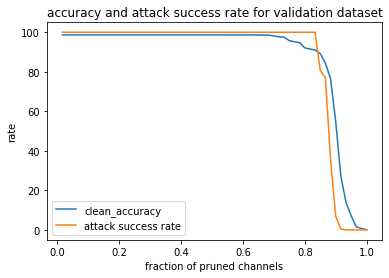

In [47]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [48]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


Now, your goodnet G works as follows. For each test input, you will run it through both B and
B'. If the classification outputs are the same, i.e., class i, you will output class i. If they differ you
will output N+1. Evaluat this defense on:
1. A BadNet, B1, (“sunglasses backdoor”) on YouTube Face for which we have already
told you what the backdoor looks like. That is, we give you the validation data, and
also test data with examples of clean and backdoored inputs.

In [49]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

In [50]:
x_test_data, y_test_data = loader('lab3/data/cl/test.h5')
x_test_poisoned_data, y_test_poisnoed_data = loader('lab3/data/bd/bd_test.h5')
test_model_X_2 = keras.models.load_model('model_X=2.h5')
test_model_X_4 = keras.models.load_model('model_X=4.h5')
test_model_X_10 = keras.models.load_model('model_X=10.h5')
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)
G_model_X_2 = G(bad_net_model, test_model_X_2)
G_model_X_4 = G(bad_net_model, test_model_X_4)
G_model_X_10 = G(bad_net_model, test_model_X_10)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


## Evaluating on the test dataset

In [51]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model, Attack Success Rate:', asr_2)

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model, Attack Success Rate:', asr_4)

cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model, Attack Success Rate:', asr_10)

401/401 [==============================] - 3s 7ms/step
2% drops model, the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 3s 7ms/step
2% drops model, Attack Success Rate: 100.0
401/401 [==============================] - 3s 7ms/step
4% drops model, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 3s 7ms/step
4% drops model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 3s 7ms/step
10% drops model, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 3s 7ms/step
10% drops model, Attack Success Rate: 77.20966484801247


Summarizing the fixed models

In [52]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


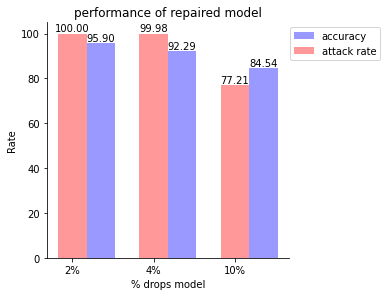

In [53]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

In [54]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [55]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


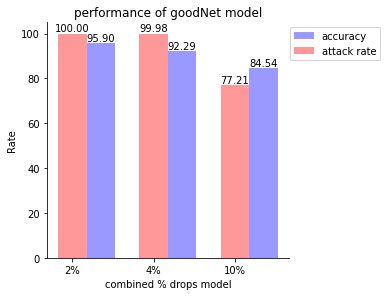

In [56]:
opacity = 0.4
bar_width = 0.35
plt.xlabel('combined % drops model')
plt.ylabel('Rate')
plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()